In [2]:
import sys

sys.path.append("../../src/groundstate_prep")
from ground_state_prep import prepare_ground_state
from utils_gsp import approx_polynomial, get_phis, U

sys.path.append("../../src/lindbladian")
from lindbladian import ideal_lindbladian, circuit_implementation_lindbladian
from utils_lind import crandn, filter_function

In [3]:
# Hamiltonian.

import numpy as np
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt

# Parameters for the Ising Hamiltonian
# L has to be even! Due to K only being able to control even Ls!
L, J, g = (6, 1, 1)


# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
hamil = qib.IsingHamiltonian(field, J, 0, g).as_matrix().toarray()

eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]
print("Ground State Energy", eigenvalues_sort[0].real)

Ground State Energy -7.727406610312517


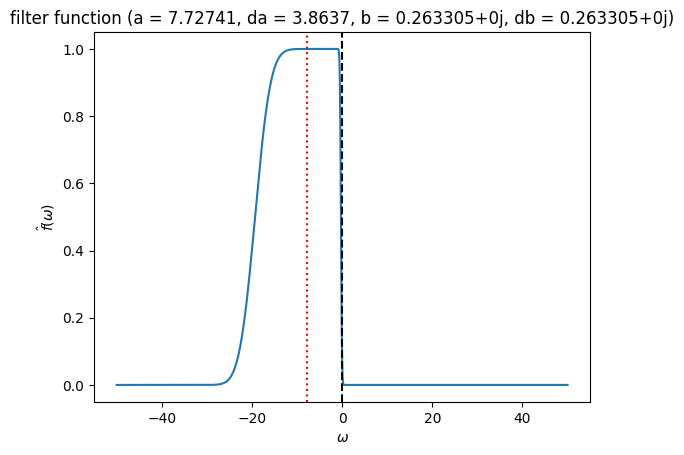

In [6]:
# Visualize the filter function that will be used for Linbladian sim. in frequency domain.

Sw = np.linalg.norm(hamil, ord=2)
gap = eigenvalues_sort[1] - eigenvalues_sort[0]
a, da, b, db  = (2.5*Sw, 0.5*Sw, gap, gap)
fhat = lambda w: filter_function(w, a, da, b, db)

wlist = np.linspace(-50, 50, 1001, endpoint=True)
plt.plot(wlist, np.abs(fhat(wlist)))
plt.xlabel(r"$\omega$")
plt.ylabel(r"$\hat{f}(\omega)$")
plt.title(f"filter function (a = {Sw:g}, da = {da:g}, b = {b:g}, db = {db:g})")
plt.axvline(0, color="k", linestyle="--")
plt.axvline(-Sw, color="r", linestyle=":")
plt.show()

Absolute Error for the Eigenvalue:  0.4731727540735058
State fidelity to the ground state:  0.7585850631971753


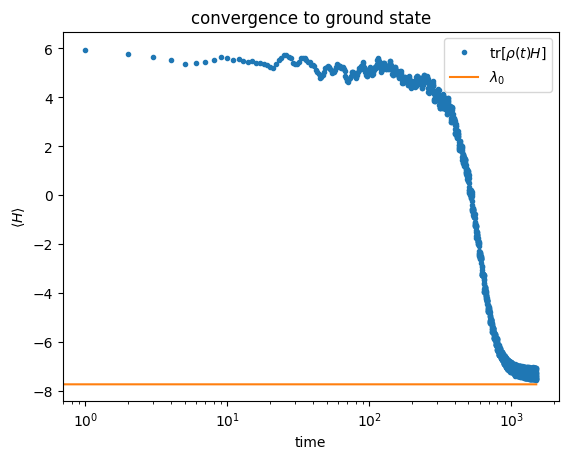

In [4]:
from qiskit.quantum_info import state_fidelity

tau, nsteps = (1, 1500)
end_state_lind, en_list, err = circuit_implementation_lindbladian(hamil, L, tau=tau, nsteps=nsteps)

print("Absolute Error for the Eigenvalue: ", err)
print("State fidelity to the ground state: ", state_fidelity(end_state_lind, ground_state))
plt.semilogx(tau * np.arange(nsteps + 1), en_list, ".", label=r"$\mathrm{tr}[\rho(t) H]$")
plt.semilogx(tau * np.arange(nsteps + 1), (eigenvalues_sort[0]*np.ones(nsteps + 1)).real, label=r"$\lambda_0$")
plt.legend()
plt.xlabel("time")
plt.ylabel(r"$\langle H \rangle$")
plt.title("convergence to ground state")
plt.show()

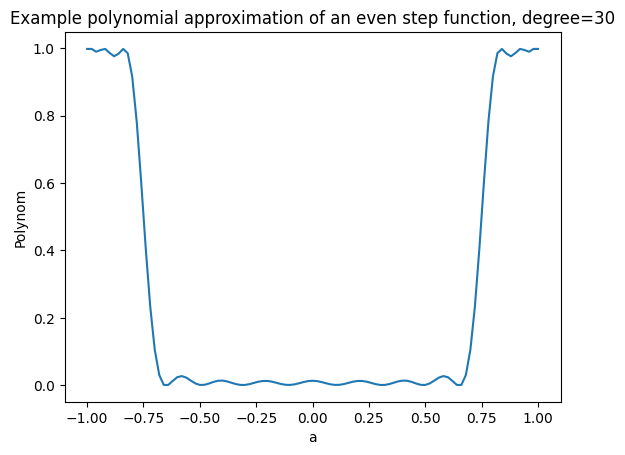

In [4]:
# We will used the prepared state in the QETU algorithm to further better the state fidelity.
# This gives the advantage of zooming into energy spectrum as the initial overlap with higher
# energy states will be negligible. We also get a higher probability of measuring 0 at our ancilla qubit.

x_list = np.linspace(-1, 1, 301)
M, d, sigma_minus, sigma_plus, c, eps = (500, 30, 0.7, 0.8, 0.999, 0.001)
mu = (sigma_minus+sigma_plus)/2
polynom, even_coeffs = approx_polynomial(M, d, sigma_minus, sigma_plus, c, eps)
plt.title(f"Example polynomial approximation of an even step function, degree={d}")
plt.xlabel("a")
plt.ylabel("Polynom")
x_list = np.linspace(-1, 1, 101)
plt.plot(x_list, polynom(x_list))
plt.show()

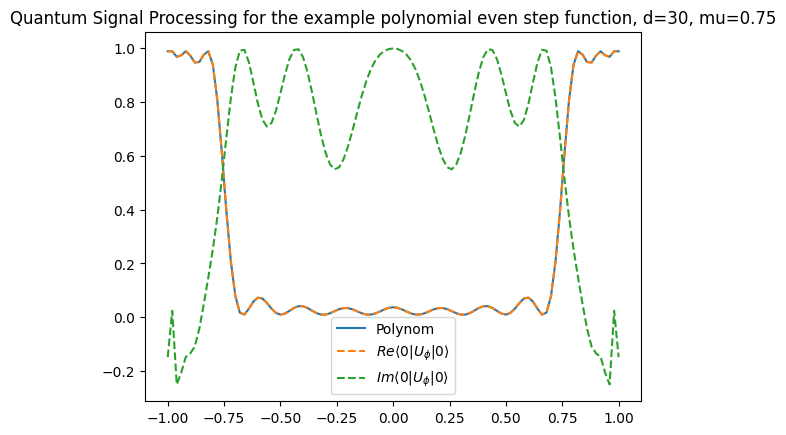

In [6]:
phis, phi_primes, poly_even_step = get_phis(mu, d, 0.01, c=c)

a_list = np.linspace(-1, 1, 101)
ket_0 = np.array([1,0])
qsp_polynom = [poly_even_step(a) for a in a_list]
plt.plot(a_list, qsp_polynom, label="Polynom")
qsp_polynom = [np.vdot(ket_0, U(phi_primes, a)@ket_0).real for a in a_list]
plt.plot(a_list, qsp_polynom, "--", label=r"$Re{\langle0|U_{\phi}|0\rangle}$")
qsp_polynom = [np.vdot(ket_0, U(phi_primes, a)@ket_0).imag for a in a_list]
plt.plot(a_list, qsp_polynom, "--", label=r"$Im{\langle0|U_{\phi}|0\rangle}$")
plt.title(f"Quantum Signal Processing for the example polynomial even step function, d={d}, mu={mu}")
plt.legend()
plt.show()

In [7]:
# Linear transformation of the hamiltonian to fit the eigenvalues in the [-1, 1] interval.

dist = 0.001

# Have to be guessed, depending on the used Hamiltonian
# If we have a good initial overlap, we can decrease this 
# max_spectrum_length and get a larger spectral gap after transformation.
max_spectrum_length = 16
ground_energy_lower_bound = -9
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

print("a_max", a_values[0])
print("a_premax", a_values[1])
print("c1: ", c1)
print("c2: ", c2)

a_max (0.9921530917736707-0j)
a_premax (0.9885924745552997-0j)
c1:  0.19622454084936208
c2:  1.7670208676442587


In [8]:
mu, d, c, phis_max_iter, = (0.99, 30, 0.95, 10)

end_state_qetu, E = prepare_ground_state(
                        np.kron(ket_0, end_state_lind), mu, d, c, phis_max_iter,
                        np.kron(ket_0, ground_state), L, J, g, eigenvalues_sort[0],
                        hamil=hamil, max_reps=5, tau=c1, shift=c2, a_max=a_values[0]
)


Layer 0
Prob 0: 0.08339700191961759
Prob 1: 0.9166029980803814

Layer 1
Prob 0: 0.09804355119855418
Prob 1: 0.901956448801445

Layer 2
Prob 0: 0.10116326035131849
Prob 1: 0.8988367396486803

Layer 3
Prob 0: 0.10220183813230777
Prob 1: 0.8977981618676911

Layer 4
Prob 0: 0.10253502829601994
Prob 1: 0.8974649717039785

F(a_max) = (0.1026838363758513+0j)

 ---------- 
 SUCCESS! 

Fidelity of the initial state to the ground state: 0.7585850631971753
Fidelity of the prepared state to the ground state: 0.9993108868040559
